In [95]:
import numpy as np
import tensorflow as tf
import glob
from pydub import AudioSegment
from audioset import vggish_keras_embeddings
from time import time
import utils
import youtube_dl
import pandas as pd
import h5py
import os

%matplotlib inline

In [71]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/oppapie/projects/LaughDetection/utils.py'>

In [109]:
#url = 'https://www.youtube.com/watch?v=fpf1IYU0poY' # Trump state of the union 2019
url = 'https://www.youtube.com/watch?v=Ymwe4DB_HsU'
def download_audio(url, download=True):

    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': '%(title)s.%(ext)s',
        'writesubtitles': True,
        'writeautomaticsub': True,
        'quiet': True,
        #'progress_hooks': [my_hook],
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=download)  # Download into the current working directory
        filename = ydl.prepare_filename(result)
    return filename
filename = download_audio(url)

In [112]:
print(filename)

Toy Story Toons 'Small Fry' Sneak Peek.webm


In [113]:
start = time()
def embed_audio(filename, savename=filename+'.h5'):
    exists = os.path.isfile(savename)
    if exists:
        print('Embedding file detected.')
        f = h5py.File(savename, 'r')
        return f.items()
    else:
        print('Embedding file not detected.')
        print('Running embedder on audio.')
        list_of_embeddings = []
        audio_embedder = vggish_keras_embeddings.VGGishEmbedder(None)
        for idx, val in enumerate(utils.sound_slice_generator(filename, clipsize=1000, sample_rate=48000)):
            waveform, sample_rate = val[0], val[1]
            if val[0].shape[0] < sample_rate:
                waveform = np.pad(val[0], (0, sample_rate - val[0].shape[0]), mode='constant')
            processed_embedding =  audio_embedder.convert_waveform_to_embedding(waveform, sample_rate)

            embedding_final = np.expand_dims(processed_embedding, axis=0)
            list_of_embeddings.append((idx, embedding_final))
            if idx != 0 and idx % 100 == 0:
                print(idx, "samples embedded")
        utils.save_embeddings_hdf(filename, list_of_embeddings)
        return list_of_embeddings

predictions = []

model = tf.keras.models.load_model('Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

for idx, v in embed_audio(filename):
    predictions.append((idx, model.predict(v)))
    
end = time()
print(end - start)

W0329 14:03:39.237222 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef74eb15ef0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 14:03:39.374831 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef74f0e7b00>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 14:03:39.517725 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef74f3bf9e8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Embedding file detected.
4.824404716491699


In [90]:
predictions = []

model = tf.keras.models.load_model('Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

for idx, v in list_of_embeddings:
    predictions.append((idx, model.predict(v)))

W0329 13:24:51.809915 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f6163a20>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:24:51.956087 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f17c2be0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:24:52.102088 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f156a518>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [30]:
utils.save_embeddings_hdf(filename, list_of_embeddings)

In [74]:
f = h5py.File('President Trump Delivers the State of the Union Address.m4a.h5', 'r')

In [91]:
predictions2 = []

model = tf.keras.models.load_model('Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

for idx, v in f.items():
    predictions2.append((int(idx), model.predict(v)))
    
end = time()

W0329 13:25:31.792908 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef791df11d0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:25:31.929369 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef78cc3c630>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:25:32.066643 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef787a5b080>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [92]:
predictions[:2]

[(0, array([[0.5502941]], dtype=float32)),
 (1, array([[0.5374133]], dtype=float32))]

In [93]:
predictions2[:2]

[(0, array([[0.5502941]], dtype=float32)),
 (1, array([[0.5374133]], dtype=float32))]

In [33]:
import datetime
for i in predictions:
    if i[1] > 0.6:
        print(str(datetime.timedelta(seconds=int(i[0]/2))), f'{i[1][0][0]: .2f}')

0:54:16  0.61
1:10:35  0.60
1:17:47  0.61


## Plotting time of video vs prediction

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

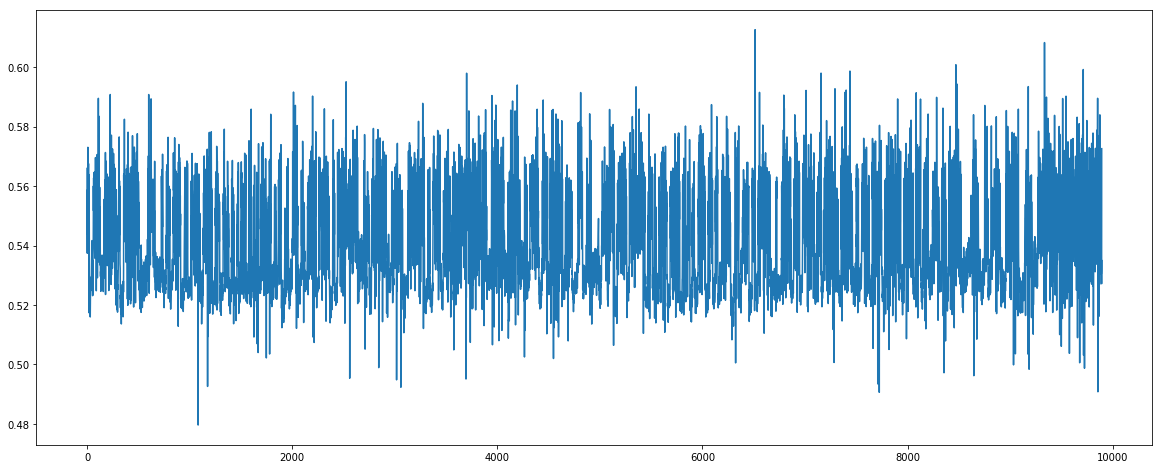

In [94]:
x = [i[0] for i in predictions]
y = [i[1][0][0] for i in predictions]
plt.figure(figsize=(20,8))
sns.lineplot(x, y)

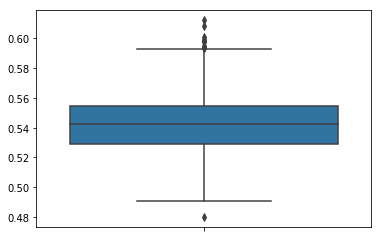

In [34]:
sns.boxplot(y=y)

## Saving predictions to csv

In [55]:
x = [datetime.timedelta(seconds=i[0]/2) for i in predictions]
y = [i[1][0][0] for i in predictions]

df = pd.DataFrame({'timestamp': x, 'prediction': y})
df.to_csv(filename+'_predictions.csv', index=False)

timestamp     timedelta64[ns]
prediction            float64
dtype: object

In [47]:
df['prediction'].describe(percentiles=np.linspace(.1,.9, num=9))

count    9894.000000
mean        0.542577
std         0.015801
min         0.479638
10%         0.523550
20%         0.527021
30.0%       0.530688
40%         0.536030
50%         0.542355
60%         0.547658
70%         0.552305
80%         0.556844
90%         0.563078
max         0.612577
Name: prediction, dtype: float64

In [69]:
df2 = pd.read_csv('President Trump Delivers the State of the Union Address.m4a_predictions.csv',)
df2['timestamp'] = pd.to_timedelta(df2['timestamp'])
df2.head()

,timestamp,prediction
0,00:00:00,0.550294
1,00:00:00.500000,0.537413
2,00:00:01,0.566119
3,00:00:01.500000,0.548482
4,00:00:02,0.558821


In [14]:
def sound_slice_generator(sound_path, clipsize=500, sample_rate=48000):
    '''
    Generates np array value from sound clip to feed into VGGish Embedder

    input:
        list_sounds: generator of slices of sound clip
        clipsize:
    returns:
        generator to feed into vggish embedder
    '''
    sound = AudioSegment.from_file(sound_path)
    sound = sound.set_frame_rate(sample_rate)
    step = int(clipsize/2)
    list_sounds = sound[::step]  # generate clipsize/2 values of the clip
    prev_iter_value = None
    for idx, v in enumerate(list_sounds):

        if idx == 0:
            prev_iter_value = v
            continue
        overlapped = prev_iter_value + v # combine current 
        samples = overlapped.get_array_of_samples()
        np_samples = np.array(samples)
        s_reshaped = np_samples.reshape((-1,2))
        prev_iter_value = v
        #print(idx, s_reshaped.shape)
        yield s_reshaped, v.frame_rate

In [6]:
for idx, val in enumerate(sound_slice_generator('The Speech that Made Obama President.webm', 1000)):
    print(idx)

TypeError: slice indices must be integers or None or have an __index__ method